## Merging Files

In [2]:
import csv

# Generate filenames programmatically
path = "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTBBE/1000simXgb2_2000mData"
files = [path + "/getXGBoostTrainingData_{}.csv".format(i) for i in range(1000)]

merged_filename = "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTraining/dataXgb3Training/XGB_merged_result.csv"

with open(merged_filename, "w", newline="") as outfile:
    writer = csv.writer(outfile)

    for index, filename in enumerate(files):
        with open(filename, "r") as infile:
            reader = csv.reader(infile)

            # Skip header only if it's not the first file
            if index != 0:
                next(reader, None)

            # Write rows from current file to the output file
            writer.writerows(reader)

## Sorting values by balance

In [3]:
import pandas as pd

# Read the merged CSV file into a DataFrame
df = pd.read_csv(
    "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTraining/dataXgb3Training/XGB_merged_result.csv"
)

# Sort the DataFrame by balance in descending order
df_sorted = df.sort_values(by="balance", ascending=False)

df_sorted.head(100)

,type,competitorID,time,exchange,odds,agentID,stake,distance,rank,balance,decision
7969652,Trade,4,161.257595,0,4.971776,52,15,1780.245314,1,1.000865e+08,backer
7974114,Trade,4,170.098934,0,4.092972,52,15,1916.652856,1,1.000865e+08,backer
7974124,Trade,4,170.103411,0,4.442264,52,15,1916.652856,1,1.000865e+08,backer
7970306,Trade,4,163.472342,0,5.005369,52,15,1810.221777,1,1.000865e+08,backer
7974122,Trade,4,170.102699,0,4.442264,52,15,1916.652856,1,1.000865e+08,backer
...,...,...,...,...,...,...,...,...,...,...,...
7970234,Trade,4,163.390787,0,5.041151,52,15,1810.221777,1,1.000865e+08,backer
7974084,Trade,4,170.084200,0,4.799857,52,15,1916.652856,1,1.000865e+08,backer
7974078,Trade,4,170.082803,0,4.799857,52,15,1916.652856,1,1.000865e+08,backer
7974074,Trade,4,170.081384,0,4.446525,52,15,1916.652856,1,1.000865e+08,backer


## Saving top 20% of values for training

In [4]:
# Calculate 20% of the total number of rows and retrieve the top rows
top_20_percent = int(0.20 * len(df_sorted))
top_20_df = df_sorted.head(top_20_percent)

# Save the top 20% rows to a new CSV file, if desired
top_20_df.to_csv(
    "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTraining/dataXgb3Training/XGB_Top_20%.csv",
    index=False,
)

## Pre-processing and splitting of data

In [5]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Import the data
data = pd.read_csv(
    "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTraining/dataXgb3Training/XGB_Top_20%.csv"
)
decision_counts = data["decision"].value_counts()
print(decision_counts)


# Remove potentially irrelevant columns
data = data.drop(
    columns=["type", "competitorID", "exchange", "agentID", "balance", "odds"]
)

# Column that has left: time  odds  stake  distance  rank

# Convert 'decision' column to binary: 1 for 'backer' and 0 for 'layer'
data["decision"] = data["decision"].map({"backer": 1, "layer": 0})

# Split data into training and testing sets
X = data.drop(columns="decision")
print(X.head())
y = data["decision"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

decision
layer     1783910
backer     768457
Name: count, dtype: int64
         time  stake     distance  rank
0  161.257595     15  1780.245314     1
1  170.098934     15  1916.652856     1
2  170.103411     15  1916.652856     1
3  163.472342     15  1810.221777     1
4  170.102699     15  1916.652856     1


## Model Training

In [6]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report


# Define the function to optimize
def bo_tune_xgb(eta, max_depth, subsample, colsample_bytree, gamma, alpha, lambda_):
    params = {
        "eta": eta,
        "max_depth": int(max_depth),
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "gamma": gamma,
        "alpha": alpha,
        "lambda": lambda_,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "n_estimators": 100,
        "random_state": 42,
    }
    cv_result = xgb.cv(params, dtrain, nfold=5)
    y_pred = xgb.train(params, dtrain, num_boost_round=100).predict(xgb.DMatrix(X_test))
    y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]  # Apply threshold
    return accuracy_score(y_test, y_pred)


# Convert training data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the bounds of the hyperparameters to optimize
hyperparameter_space = {
    "eta": (0.1, 0.6),
    "max_depth": (5, 8),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.5, 1.0),
    "gamma": (0, 0.4),
    "alpha": (0, 2.0),
    "lambda_": (0, 3.0),
}

# Initialize Bayesian optimizer
optimizer = BayesianOptimization(
    f=bo_tune_xgb, pbounds=hyperparameter_space, random_state=42, verbose=2
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=50)

# Print best parameters and score
print("Best parameters found:", optimizer.max["params"])
print("Best cross-validation score:", optimizer.max["target"])

# Use the best model for prediction and evaluation
best_params = optimizer.max["params"]
best_params["max_depth"] = int(best_params["max_depth"])
best_model = xgb.train(best_params, dtrain, num_boost_round=100)

y_pred_best = best_model.predict(xgb.DMatrix(X_test))
y_pred_best = [1 if pred > 0.5 else 0 for pred in y_pred_best]  # Apply threshold
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy (Best Model):", accuracy_best)
print(classification_report(y_test, y_pred_best))

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   |  lambda_  | max_depth | subsample |
-------------------------------------------------------------------------------------------------------------


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:33:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:33:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:33:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:33:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 1         | 0.7744    | 0.7491    | 0.9754    | 0.466     | 0.2395    | 0.4681    | 5.468     | 0.529     |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:34:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:34:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:34:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 2         | 0.7989    | 1.732     | 0.8006    | 0.454     | 0.008234  | 2.91      | 7.497     | 0.6062    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:34:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:34:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:34:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:34:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 3         | 0.763     | 0.3636    | 0.5917    | 0.2521    | 0.2099    | 1.296     | 5.874     | 0.8059    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:34:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:34:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:34:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 4         | 0.7638    | 0.279     | 0.6461    | 0.2832    | 0.1824    | 2.356     | 5.599     | 0.7571    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:35:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:35:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:35:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:35:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 5         | 0.7753    | 1.185     | 0.5232    | 0.4038    | 0.06821   | 0.1952    | 7.847     | 0.9828    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:35:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:35:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:35:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:35:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 6         | 0.8271    | 2.0       | 1.0       | 0.6       | 0.4       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:35:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:35:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:35:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 7         | 0.8277    | 2.0       | 1.0       | 0.6       | 0.4       | 2.092     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 8         | 0.8271    | 0.0       | 1.0       | 0.6       | 0.4       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 9         | 0.7933    | 0.9385    | 1.0       | 0.1       | 0.4       | 2.542     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 10        | 0.7905    | 0.0       | 0.5       | 0.6       | 0.4       | 3.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:37:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:37:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:37:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:37:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 11        | 0.8175    | 2.0       | 1.0       | 0.6       | 0.4       | 2.095     | 7.176     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:38:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:38:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:38:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 12        | 0.7917    | 2.0       | 0.5       | 0.6       | 0.0       | 2.358     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:38:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:38:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:38:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:38:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 13        | 0.8133    | 2.0       | 1.0       | 0.6       | 0.4       | 1.571     | 7.788     | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:38:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:38:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:38:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 14        | 0.7906    | 2.0       | 1.0       | 0.1       | 0.4       | 2.532     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:39:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:39:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:39:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:39:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 15        | 0.7771    | 0.8566    | 0.6636    | 0.3588    | 0.3926    | 0.05051   | 7.672     | 0.7597    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:39:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:39:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:39:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 16        | 0.7619    | 0.01295   | 0.7415    | 0.2454    | 0.2345    | 1.533     | 5.479     | 0.9832    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:40:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:40:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:40:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 17        | 0.828     | 0.0       | 1.0       | 0.6       | 0.0       | 2.408     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:40:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:40:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:40:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:40:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 18        | 0.8171    | 0.0       | 1.0       | 0.6       | 0.0       | 2.949     | 7.355     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:40:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:40:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:40:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:40:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 19        | 0.8272    | 0.0       | 1.0       | 0.6       | 0.4       | 1.666     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 20        | 0.8168    | 0.0       | 1.0       | 0.6       | 0.4       | 2.169     | 7.44      | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 21        | 0.8037    | 2.0       | 1.0       | 0.6       | 0.4       | 3.0       | 6.212     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 22        | 0.8236    | 0.0       | 1.0       | 0.6       | 0.0       | 1.359     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:42:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 23        | 0.828     | 0.7207    | 1.0       | 0.6       | 0.0       | 1.606     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:43:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 24        | 0.7921    | 0.0       | 1.0       | 0.1       | 0.0       | 1.457     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:43:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:43:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:43:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:43:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 25        | 0.8228    | 0.6199    | 1.0       | 0.6       | 0.4       | 1.757     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:43:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:43:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:43:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 26        | 0.828     | 1.371     | 1.0       | 0.6       | 0.4       | 1.555     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:44:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:44:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:44:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:44:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 27        | 0.7652    | 2.0       | 0.5       | 0.6       | 0.0       | 3.0       | 5.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:44:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:44:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:44:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:45:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 28        | 0.8279    | 0.7088    | 1.0       | 0.6       | 0.0       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:45:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 29        | 0.8168    | 1.167     | 1.0       | 0.6       | 0.4       | 3.0       | 7.368     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 30        | 0.7903    | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 5.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:46:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:46:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:46:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 31        | 0.8263    | 0.6524    | 1.0       | 0.6       | 0.4       | 2.164     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 32        | 0.8286    | 2.0       | 1.0       | 0.6       | 0.4       | 1.218     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 33        | 0.8283    | 2.0       | 1.0       | 0.6       | 0.0       | 1.501     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 34        | 0.8249    | 0.0       | 1.0       | 0.6       | 0.4       | 0.7754    | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 35        | 0.8278    | 1.23      | 1.0       | 0.6       | 0.0       | 2.085     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:48:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:48:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:48:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 36        | 0.8217    | 2.0       | 1.0       | 0.6       | 0.4       | 3.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:48:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:48:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 37        | 0.8169    | 2.0       | 1.0       | 0.6       | 0.0       | 1.077     | 7.26      | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:49:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:49:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:49:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 38        | 0.8242    | 0.0       | 1.0       | 0.6       | 0.0       | 0.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:49:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 39        | 0.8139    | 0.0       | 1.0       | 0.6       | 0.0       | 0.0       | 7.1       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:49:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 40        | 0.8287    | 0.0       | 1.0       | 0.6       | 0.4       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 41        | 0.8291    | 0.0       | 1.0       | 0.6       | 0.0       | 0.5113    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 42        | 0.829     | 1.467     | 1.0       | 0.6       | 0.0       | 1.265     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 43        | 0.7902    | 0.0       | 0.5       | 0.6       | 0.0       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 44        | 0.8274    | 1.348     | 1.0       | 0.6       | 0.4       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 45        | 0.8174    | 0.0       | 1.0       | 0.6       | 0.4       | 0.6412    | 7.535     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:52:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:52:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 46        | 0.8288    | 0.5254    | 1.0       | 0.6       | 0.4       | 0.9507    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:52:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:52:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 47        | 0.8287    | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 48        | 0.8183    | 2.0       | 1.0       | 0.6       | 0.4       | 0.0       | 7.361     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 49        | 0.8251    | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:54:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 50        | 0.8249    | 0.7335    | 1.0       | 0.6       | 0.0       | 0.9496    | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:54:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:54:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:54:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:54:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 51        | 0.8299    | 2.0       | 1.0       | 0.6       | 0.0       | 0.642     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:54:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:54:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 52        | 0.8293    | 2.0       | 1.0       | 0.6       | 0.4       | 0.1951    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 53        | 0.8278    | 0.0       | 1.0       | 0.6       | 0.0       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 54        | 0.8302    | 0.0       | 1.0       | 0.6       | 0.4       | 0.5906    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 55        | 0.8295    | 0.2938    | 1.0       | 0.6       | 0.0       | 1.007     | 8.0       | 1.0       |
Best parameters found: {'alpha': 0.0, 'colsample_bytree': 1.0, 'eta': 0.6, 'gamma': 0.4, 'lambda_': 0.5905564380233321, 'max_depth': 8.0, 'subsample': 1.0}
Best cross-validation score: 0.8301558943256659


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (Best Model): 0.7966595752183265
              precision    recall  f1-score   support

           0       0.81      0.92      0.86    356836
           1       0.74      0.50      0.60    153638

    accuracy                           0.80    510474
   macro avg       0.77      0.71      0.73    510474
weighted avg       0.79      0.80      0.78    510474



## Boxplot of parameters


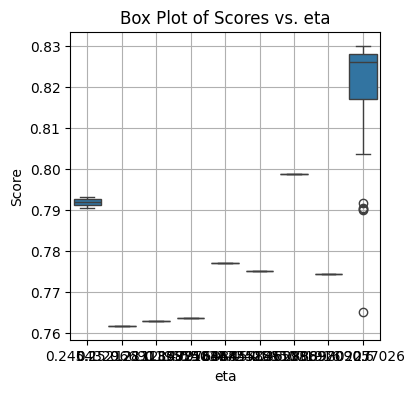

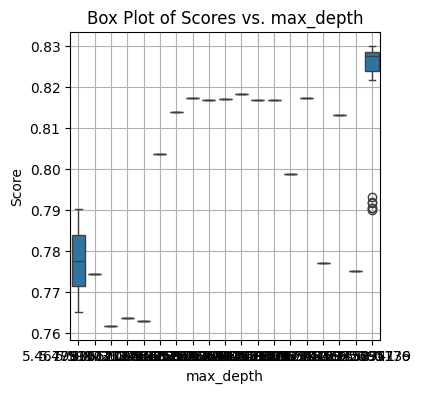

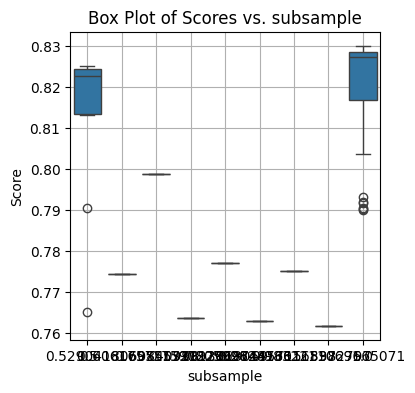

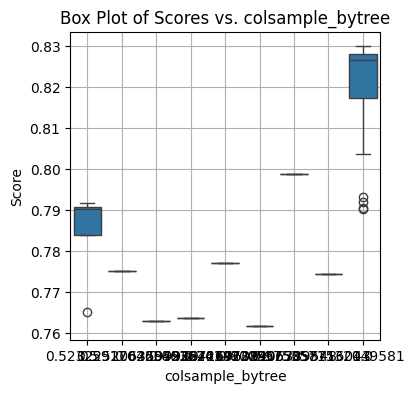

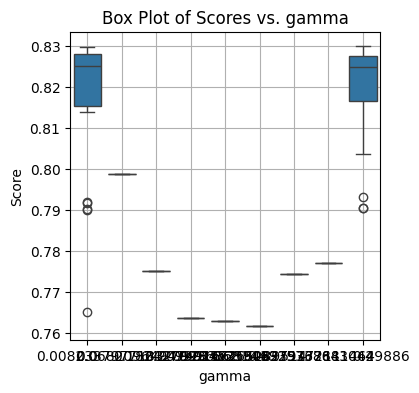

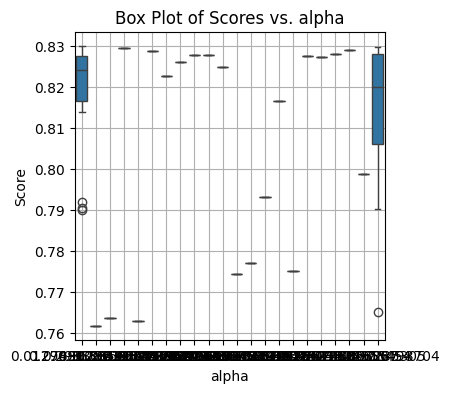

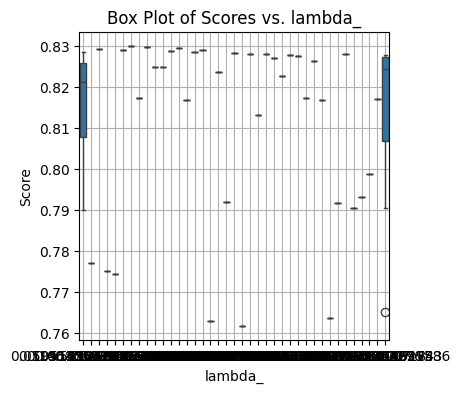

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the optimization results to a dataframe
results_df = pd.DataFrame(optimizer.res)

# Extract the parameters into separate columns
for param in hyperparameter_space.keys():
    results_df[param] = results_df["params"].apply(lambda params: params[param])

# Melt the dataframe for seaborn
melted_scores_df = results_df.melt(
    id_vars=list(hyperparameter_space.keys()),
    value_vars=["target"],
    var_name="iteration",
    value_name="score",
)

for param in hyperparameter_space.keys():
    plt.figure(figsize=(4, 4))

    # Boxplot
    sns.boxplot(data=melted_scores_df, x=param, y="score")
    plt.title(f"Box Plot of Scores vs. {param}")
    plt.ylabel("Score")
    plt.grid(True)
    plt.show()

## Model evaluation and performance visualisation 

Accuracy: 0.7966595752183265

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86    356836
           1       0.74      0.50      0.60    153638

    accuracy                           0.80    510474
   macro avg       0.77      0.71      0.73    510474
weighted avg       0.79      0.80      0.78    510474



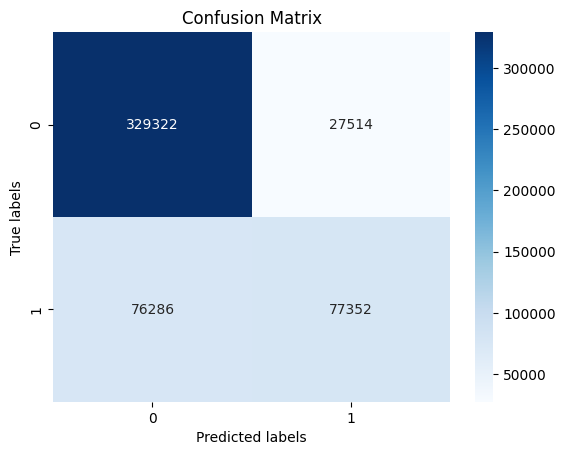

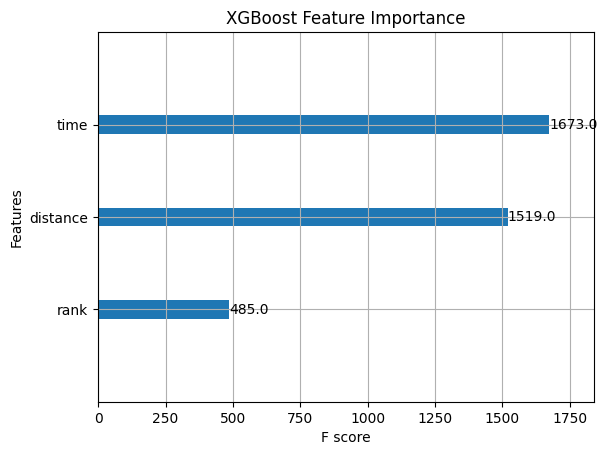

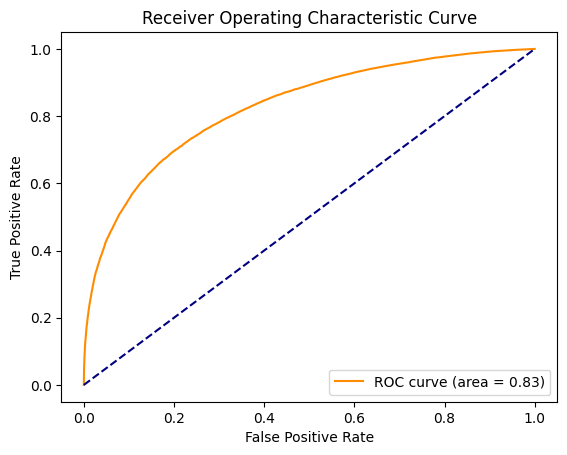

PR AUC: 0.7138539828545732


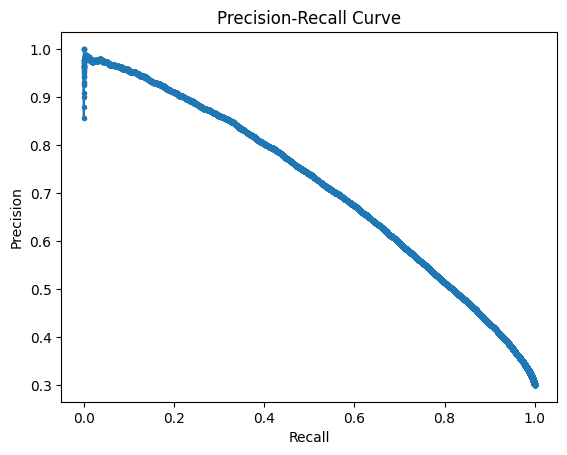

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
import seaborn as sns
import joblib

# 1. Testing on the Test Set
y_pred = y_pred_best

# 2. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# 3. Visualization

# Feature Importance
xgb.plot_importance(best_model)
plt.title("XGBoost Feature Importance")
plt.show()

# ROC Curve
y_pred_proba = best_model.predict(xgb.DMatrix(X_test))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
# Compute and print AUC for Precision-Recall Curve
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc}")
plt.show()

## Train-test error progression plot

Best parameters found: {'alpha': 0.0, 'colsample_bytree': 1.0, 'eta': 0.6, 'gamma': 0.4, 'lambda_': 0.5905564380233321, 'max_depth': 8, 'subsample': 1.0}


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


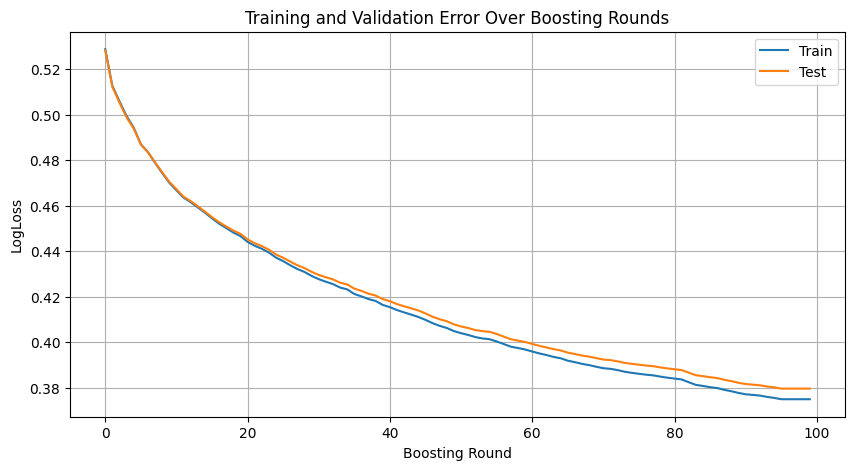

In [9]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Use the best parameters from the Bayesian optimization
print("Best parameters found:", best_params)

# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic", random_state=42, n_estimators=100, **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

## N_Estimators and Early stopping

In [10]:
# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_estimators=2000,  # Increasing n_estimators to 2000
    **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=20,  # Increasing early stopping rounds to 20
    verbose=False,
)

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.6, eval_metric='logloss',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda_=0.5905564380233321, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, ...)

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


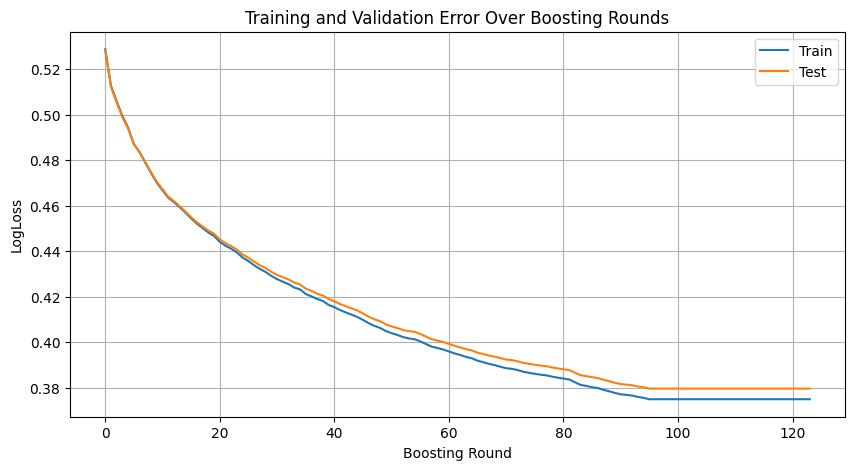

In [11]:
# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=20,  # Increasing early stopping rounds to 20
    verbose=False,
)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


Best iteration: 103


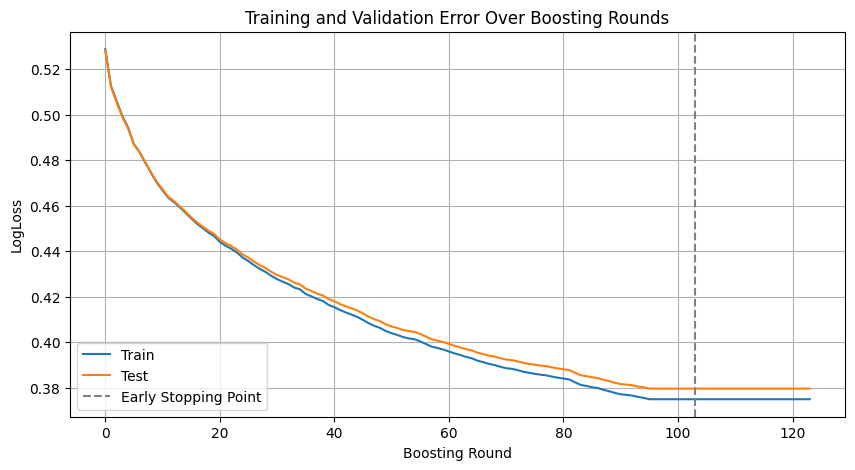

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.767251 to fit


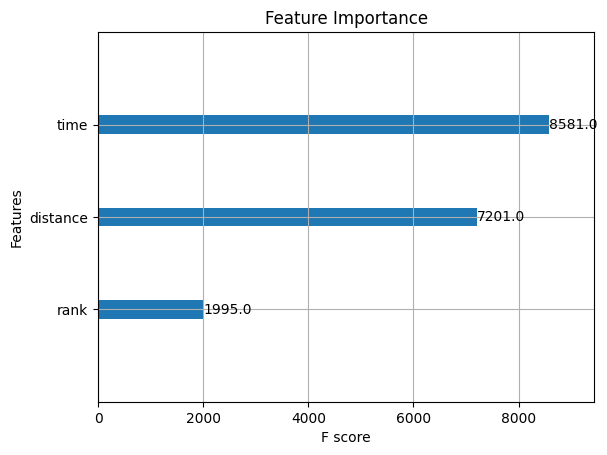

    Feature  Importance
3      rank    0.691141
2  distance    0.164528
0      time    0.144331
1     stake    0.000000


In [12]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_estimators=2000,  # Increasing n_estimators to 2000
    **best_params,
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=20,  # Increasing early stopping rounds to 20
    verbose=False,
)

# 1. Print the boosting round where early stopping occurred:
print(f"Best iteration: {best_xgb_estimator.get_booster().best_iteration}")

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.axvline(
    x=best_xgb_estimator.get_booster().best_iteration,
    color="gray",
    linestyle="--",
    label="Early Stopping Point",
)
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

# 2. Visualize the model using XGBoost's plot functionalities:

# a. Plotting the first tree:
xgb.plot_tree(best_xgb_estimator, num_trees=0)
plt.show()

# b. Displaying the importance of each feature:
xgb.plot_importance(best_xgb_estimator)
plt.title("Feature Importance")
plt.show()

# Feature importances:
importances = best_xgb_estimator.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame(
    {"Feature": features, "Importance": importances}
).sort_values(by="Importance", ascending=False)
print(feature_importance_df)

              precision    recall  f1-score   support

           0       0.84      0.93      0.88    356836
           1       0.79      0.59      0.67    153638

    accuracy                           0.83    510474
   macro avg       0.81      0.76      0.78    510474
weighted avg       0.82      0.83      0.82    510474

[[332928  23908]
 [ 63692  89946]]


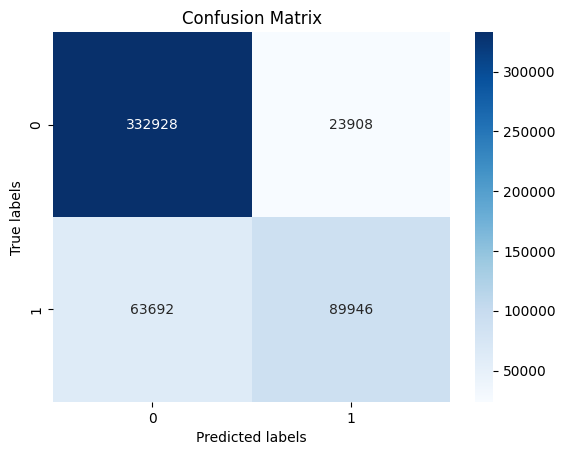

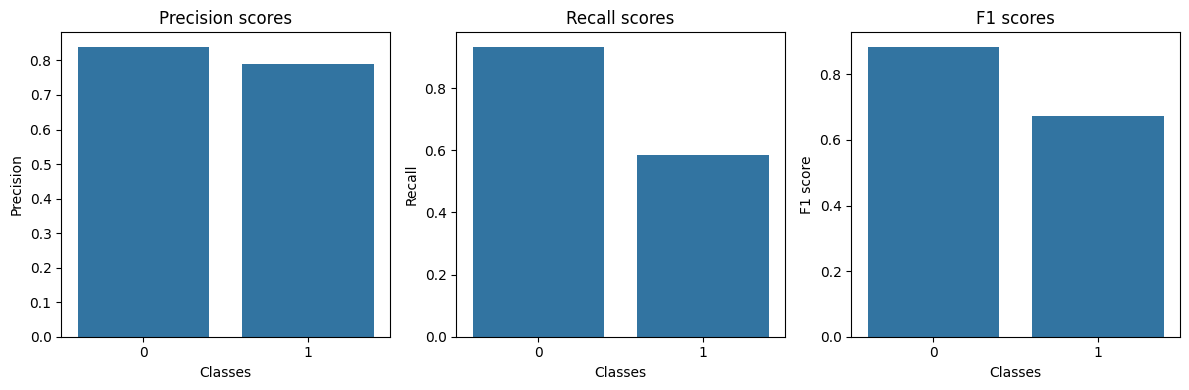

In [13]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict the classes
y_pred = best_xgb_estimator.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Visualizing the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Precision, recall, f1-score plots for each class
precision, recall, f1score, _ = precision_recall_fscore_support(
    y_test, y_pred, average=None
)

plt.figure(figsize=(12, 4))

plt.subplot(131)
sns.barplot(x=np.unique(y_test), y=precision)
plt.title("Precision scores")
plt.xlabel("Classes")
plt.ylabel("Precision")

plt.subplot(132)
sns.barplot(x=np.unique(y_test), y=recall)
plt.title("Recall scores")
plt.xlabel("Classes")
plt.ylabel("Recall")

plt.subplot(133)
sns.barplot(x=np.unique(y_test), y=f1score)
plt.title("F1 scores")
plt.xlabel("Classes")
plt.ylabel("F1 score")

plt.tight_layout()
plt.show()

## Saving the model


In [14]:
# Save the best model to a .json file
best_model.save_model("Trained_XGB3_model.json")